In [1]:
import nilearn as nl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import time
import os
import math

### Data Generation

In [251]:
#Define the rewiring probabilities of two groups
pws_1 = 0.9
pws_2 = 0.67
num_trn = 1800
num_val = 200
num_node = 50
avg_degree = 10

#Computation graph params
num_layer = 2
input_size = 1275
output_size = 1
num_hidden_units = 500
dp_rate = 0.5
wd_rate = 0.001
l_r = 0.00015
num_epoch = 100
batch_size = 10

np.random.seed((int)(time.time()))

In [252]:
#Function to generate Watts-Strogatz Networks
def w_s_network(num_node, pws, avg_degree):
    adjacency_matrix = np.zeros((num_node, num_node))
    
    #Connect each node to avg_degree/2 nearest neighbour (eg. node 0 will connect to node 1 and node num_node-1)
    half_k = (int)(avg_degree/2)
    
    for node_i in range(num_node):
        start = node_i - half_k
        index = start - 1
        for j in range(avg_degree):
            index = index + 1
            if index == node_i:
                index = index + 1
            if index >= num_node:
                index = index - num_node
            if adjacency_matrix[node_i, index] != 1:
                adjacency_matrix[node_i, index] = 1
    
    #Rewiring connections
    prob_matrix = np.random.rand(num_node, num_node)
    for node_i in range(num_node):
        prob_matrix[node_i, node_i] = 1
    
    for node_i in range(num_node):
        for node_j in range(num_node):
            if adjacency_matrix[node_i, node_j] == 1 and prob_matrix[node_i, node_j] < pws:
                adjacency_matrix[node_i, node_j] = 0
                adjacency_matrix[node_j, node_i] = 0
                
                rewired = False
                while rewired == False:
                    index_i = np.random.randint(num_node)
                    index_j = np.random.randint(num_node)
                    if index_i != index_j and adjacency_matrix[index_i, index_j] == 0:
                        adjacency_matrix[index_i, index_j] = 1
                        adjacency_matrix[index_j, index_i] = 1
                        rewired = True
    
    return adjacency_matrix

In [253]:
#Randomly generate 1000 samples (800 trn and 200 val)
#Each sample has 50 nodes and each node has average degree of 8
data = {}

trn_x = np.zeros((num_trn, num_node * num_node))
trn_y = np.zeros((num_trn, 1))
val_x = np.zeros((num_val, num_node * num_node))
val_y = np.zeros((num_val, 1))

for i in range(num_trn):
    group = np.random.randint(2)
    if group == 0:
        sample_x = w_s_network(50, pws_1, avg_degree)
        sample_y = 0
    
    if group == 1:
        sample_x = w_s_network(50, pws_2, avg_degree)
        sample_y = 1
    
    trn_x[i, :] = sample_x.reshape(1, -1)
    trn_y[i] = sample_y

for i in range(num_val):
    group = np.random.randint(2)
    if group == 0:
        sample_x = w_s_network(50, pws_1, avg_degree)
        sample_y = 0
    
    if group == 1:
        sample_x = w_s_network(50, pws_2, avg_degree)
        sample_y = 1
    
    val_x[i, :] = sample_x.reshape(1, -1)
    val_y[i] = sample_y

data['trn_x'] = trn_x
data['trn_y'] = trn_y
data['val_x'] = val_x
data['val_y'] = val_y

pkl.dump(data, open(os.path.join('.', 'data.p'), 'wb'))

In [254]:
#Truncate each sample to save only the bottom left part
truncated_vector_size = (int)((1+num_node)*num_node/2)
truncated_data = {}
truncated_data['trn_y'] = data['trn_y']
truncated_data['val_y'] = data['val_y']
truncated_data['trn_x'] = np.zeros((num_trn, truncated_vector_size))
truncated_data['val_x'] = np.zeros((num_val, truncated_vector_size))
for i in range(num_trn):
    truncated_trn_x = np.zeros((1, truncated_vector_size))
    start = 0
    for j in range(num_node):
        start = start + j
        truncated_trn_x[0, start:start+j] = data['trn_x'][i, j*num_node : j*num_node + j]
    truncated_data['trn_x'][i, ] = truncated_trn_x

for i in range(num_val):
    truncated_val_x = np.zeros((1, truncated_vector_size))
    start = 0
    for j in range(num_node):
        start = start + j
        truncated_val_x[0, start:start+j] = data['val_x'][i, j*num_node : j*num_node + j]
    truncated_data['val_x'][i, ] = truncated_val_x
    
pkl.dump(truncated_data, open(os.path.join('.', 'truncated_data.p'), 'wb'))

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.]
[1.]


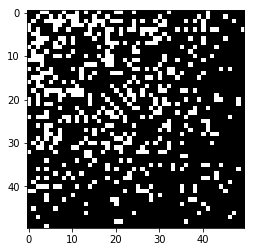

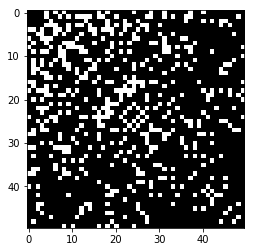

In [255]:
data_t = pkl.load(open( "data.p", "rb" ))
truncated_data_t = pkl.load(open( "truncated_data.p", "rb" ))

trn_sample = data_t['trn_x'][55, ]
trn_sample_t = truncated_data_t['trn_x'][55, ]
print(trn_sample)
print(trn_sample_t)
print(data_t['trn_y'][55])
val_sample = data_t['val_x'][114, ]
print(data_t['val_y'][114])

#m = m.reshape(50, -1)

plt.imshow(trn_sample.reshape(50, 50), cmap='gray')
plt.show()
plt.imshow(val_sample.reshape(50, 50), cmap='gray')
plt.show()

### Build Computation Graph

In [256]:
def forward_prop(cur_layer, out_size, dp_rate, is_input):
    
    _, cur_size = [item.value for item in cur_layer.shape]
        
    var = 2.0 / (cur_size + out_size)

    stddev = math.sqrt(var)

    print("steddev is", stddev)
    print(out_size)

    with tf.name_scope('fc'):
        W_fc = tf.Variable(tf.truncated_normal(shape=[cur_size,out_size], stddev=stddev))
        b_fc = tf.Variable(tf.constant(0.0, shape=[out_size]))
        if is_input is False: 
            cur_layer = tf.nn.dropout(cur_layer, 1 - dp_rate)
        out_layer = tf.matmul(cur_layer, W_fc) + b_fc

    return out_layer

def activation(cur_layer, is_output=False):
    if is_output is True:
        return tf.nn.sigmoid(cur_layer)
    return tf.nn.leaky_relu(cur_layer)

def loss_function(yhat, y):
    '''
    '''
    # get the weight decay terms
    with tf.name_scope('wd_term'):
        wght_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='fc')
        wd_term = wd_rate * tf.stack([tf.nn.l2_loss(i) for i in wght_params])

    with tf.name_scope('crit_loss'):
            crit = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=yhat)) + tf.reduce_sum(wd_term)

    return crit

def generate_dataset(x, y, shuffle=True):
    with tf.name_scope('dataset'):
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
        if shuffle: 
            dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
        else:
            dataset = dataset.batch(batch_size)

    return dataset.make_initializable_iterator()

In [257]:
#Build the actual graph
tf.reset_default_graph()
x_place = tf.placeholder('float', [None, input_size], name='input_x')
y_place = tf.placeholder('float', [None,  output_size], name='target_y')
dp_place = tf.placeholder(tf.float32, name='dropout_value')

cur_layer = x_place

for i in range(num_layer):
    print(i)
    if i != (num_layer - 1):
        print(cur_layer.shape, flush=True)
        cur_layer = forward_prop(cur_layer, num_hidden_units, dp_place, i == 0)
        cur_layer = activation(cur_layer)
    else:
        print(cur_layer.shape, flush=True)
        cur_layer = forward_prop(cur_layer, output_size, dp_place, i == 0)
        yhat_op = activation(cur_layer, True)

#Cross entropy loss
loss_op = loss_function(yhat_op, y_place)
tf.summary.scalar('Cross_Entropy_Loss', loss_op)

#adam
optimizer = tf.train.AdamOptimizer(l_r)
train_op = optimizer.minimize(loss_op)

#Accuracy
correct_pred = tf.equal(y_place, tf.round(yhat_op)) 
acc_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('Accuracy', acc_op)

#Iterators
truncated_data = pkl.load(open( "truncated_data.p", "rb" ))
trn_it = generate_dataset(truncated_data['trn_x'], truncated_data['trn_y'], shuffle=True)
val_it = generate_dataset(truncated_data['val_x'], truncated_data['val_y'], shuffle=False)

0
(?, 1275)
steddev is 0.033567254331867566
500
1
(?, 500)
steddev is 0.06318240236065634
1


In [258]:
#Actual train loop
sess = tf.Session()

# get the summary ready
merged = tf.summary.merge_all()
trn_writer = tf.summary.FileWriter("./log", sess.graph)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
meta_info['tst_loss'] = []
meta_info['tst_acc'] = []
iteration = 0
  
for ep in range(num_epoch):
    sess.run(trn_it.initializer)
    sess.run(val_it.initializer)

    trn_next_batch = trn_it.get_next()

    avg_trn_loss = 0
    avg_trn_acc = 0
    print('TRN:', flush=True)
    while True: # loop to iterate over training set
        try: 
            x, y = sess.run(trn_next_batch)
        except: 
            break
        print('+', end='', flush=True)
        iteration += 1


        _, loss_i, acc_i, summary_i, _yhat, _pred = sess.run([train_op, loss_op, acc_op, merged, yhat_op, correct_pred], 
                                                   feed_dict={x_place:x, y_place:y, dp_place:dp_rate})

        trn_writer.add_summary(summary_i, iteration)
        avg_trn_loss = avg_trn_loss + loss_i
        avg_trn_acc = avg_trn_acc + acc_i
        
        '''print(_yhat, flush=True)
        print(y, flush=True)
        print(_pred, flush=True)
        print(acc_i, flush=True)'''
    
    avg_trn_loss = avg_trn_loss*batch_size/num_trn
    avg_trn_acc = avg_trn_acc*batch_size/num_trn
    
    #Validation
    avg_val_loss = 0
    avg_val_acc = 0
    print('VAL:', flush=True)
    # evaluate the loss and accuracy
    pred_and_gt = {}
    pred_and_gt['x'] = []
    pred_and_gt['y'] = []
    pred_and_gt['yhat'] = []
    
    val_next_batch = val_it.get_next()

    while True:
        try: x, y = sess.run(val_next_batch)
        except: break
        print('+', end='', flush=True)
        
        # compute the loss
        _yhat, _loss, _acc = sess.run([yhat_op, loss_op, acc_op], 
                                   feed_dict={x_place:x, y_place:y, dp_place:0.0})

        # keep track of the loss/pred_and_gt
        pred_and_gt['x'].append(x)
        pred_and_gt['y'].append(y)
        pred_and_gt['yhat'].append(_yhat)
        avg_val_loss = avg_val_loss + _loss
        avg_val_acc = avg_val_acc + _acc
    
    avg_val_loss = avg_val_loss*batch_size/num_val
    avg_val_acc = avg_val_acc*batch_size/num_val

    print('', flush=True)

    # concatenate the list to numpy array
    for k, v in pred_and_gt.items():
        pred_and_gt[k] = np.concatenate(v)
    
    
    print('\nEp.%05d - TRN: loss %.2f VAL: loss %.2f' % (ep, avg_trn_loss, avg_val_loss), flush=True)
    print('\nEp.%05d - TRN: acc %.2f VAL: acc %.2f' % (ep, avg_trn_acc, avg_val_acc), flush=True)
        
        
    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['trn_acc'].append(avg_trn_acc)
    meta_info['val_loss'].append(avg_val_loss)
    meta_info['val_acc'].append(avg_val_acc)
    
pkl.dump(meta_info, open(os.path.join('.', 'result.p'), 'wb'))
saver.save(sess, "./model/model")
sess.close()

TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00000 - TRN: loss 0.91 VAL: loss 0.84

Ep.00000 - TRN: acc 0.61 VAL: acc 0.88
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00001 - TRN: loss 0.77 VAL: loss 0.76

Ep.00001 - TRN: acc 0.94 VAL: acc 0.94
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00002 - TRN: loss 0.72 VAL: loss 0.73

Ep.00002 - TRN: acc 0.97 VAL: acc 0.94
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00028 - TRN: loss 0.52 VAL: loss 0.56

Ep.00028 - TRN: acc 1.00 VAL: acc 0.93
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00029 - TRN: loss 0.52 VAL: loss 0.57

Ep.00029 - TRN: acc 1.00 VAL: acc 0.94
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00030 - TRN: loss 0.52 VAL: loss 0.56

Ep.00030 - TRN: acc 1.00 VAL: acc 0.94
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00056 - TRN: loss 0.52 VAL: loss 0.56

Ep.00056 - TRN: acc 1.00 VAL: acc 0.94
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00057 - TRN: loss 0.52 VAL: loss 0.56

Ep.00057 - TRN: acc 1.00 VAL: acc 0.96
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00058 - TRN: loss 0.52 VAL: loss 0.56

Ep.00058 - TRN: acc 1.00 VAL: acc 0.91
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00084 - TRN: loss 0.52 VAL: loss 0.56

Ep.00084 - TRN: acc 1.00 VAL: acc 0.93
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00085 - TRN: loss 0.52 VAL: loss 0.56

Ep.00085 - TRN: acc 1.00 VAL: acc 0.93
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++VAL:
++++++++++++++++++++

Ep.00086 - TRN: loss 0.52 VAL: loss 0.56

Ep.00086 - TRN: acc 1.00 VAL: acc 0.96
TRN:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0.2 0.305


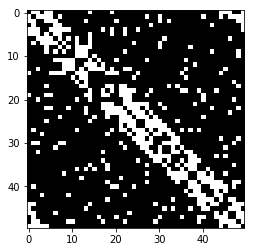

input_x
target_y
dropout_value
fc/truncated_normal/shape
fc/truncated_normal/mean
fc/truncated_normal/stddev
fc/truncated_normal/TruncatedNormal
fc/truncated_normal/mul
fc/truncated_normal
fc/Variable
fc/Variable/Assign
fc/Variable/read
fc/Const
fc/Variable_1
fc/Variable_1/Assign
fc/Variable_1/read
fc/MatMul
fc/add
LeakyRelu/alpha
LeakyRelu/mul
LeakyRelu/Maximum
fc_1/truncated_normal/shape
fc_1/truncated_normal/mean
fc_1/truncated_normal/stddev
fc_1/truncated_normal/TruncatedNormal
fc_1/truncated_normal/mul
fc_1/truncated_normal
fc_1/Variable
fc_1/Variable/Assign
fc_1/Variable/read
fc_1/Const
fc_1/Variable_1
fc_1/Variable_1/Assign
fc_1/Variable_1/read
fc_1/sub/x
fc_1/sub
fc_1/dropout/Shape
fc_1/dropout/random_uniform/min
fc_1/dropout/random_uniform/max
fc_1/dropout/random_uniform/RandomUniform
fc_1/dropout/random_uniform/sub
fc_1/dropout/random_uniform/mul
fc_1/dropout/random_uniform
fc_1/dropout/add
fc_1/dropout/Floor
fc_1/dropout/div
fc_1/dropout/mul
fc_1/MatMul
fc_1/add
Sigmoid
wd_t

[array([[0.00020623]], dtype=float32)]


In [50]:
#Little test
print(pws_1, pws_2)
tst_x_matrix = w_s_network(num_node, pws_1, avg_degree)
plt.imshow(tst_x_matrix, cmap='gray')
plt.show()

tst_x = tst_x_matrix.reshape(1, -1)
truncated_tst_x = np.zeros((1, input_size))
start = 0
for j in range(num_node):
    start = start + j
    truncated_tst_x[0, start:start+j] = tst_x[0, j*num_node : j*num_node + j]


tf.reset_default_graph()

imported_graph = tf.train.import_meta_graph('./model/model.meta')

for tensor in tf.get_default_graph().get_operations():
    print (tensor.name)

with tf.Session() as sess:
    imported_graph.restore(sess, './model/model')
    yhat = sess.run(['Sigmoid:0'], feed_dict={'input_x:0':truncated_tst_x, 'dropout_value:0':0.0})
    print(yhat)